In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import integrate
from numba import jit, njit

%matplotlib notebook

## Метод колокації

Маємо інтегральне рівняння вигляду

$$
\dots
$$

Наближений розв'язок будемо шукати у вигляді

 $$
 \tilde{\psi_k}(x)=\sum_{j=1}^{n} c^{(k)}_{j} \gamma^{(k)}_{j}(x), \quad k = 1,2
 $$

де $c_j$ - невідомі константи, які потрібно знайти, а $\gamma_j$ - задані лінійнонезалежні функції (в нашому випадку кусково аналітичні), $j = 1, ..., n$.

Розглянувши його на множині точок $x_i$, таких, що
$$
a \leqslant x_{1}<x_{2}<\ldots<x_{m} \leqslant b
$$

отримаємо СЛАР відносно невідомих $с^{(k)}_j$, $j = 1, ..., n$. 

 $$
 A =
 \begin{pmatrix}
	 \begin{matrix}
	 	G^{(1)}_{11} & \dots  & G^{(1)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(1)}_{n1} & 		  & G^{(1)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
	 	G^{(2)}_{11} & \dots  & G^{(2)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(2)}_{n1} & 		  & G^{(2)}_{nn} \\
	 \end{matrix} \\
	 \begin{matrix}
		G^{(3)}_{11} & \dots  & G^{(3)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(3)}_{n1} & 		  & G^{(3)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
		G^{(4)}_{11} & \dots  & G^{(4)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(4)}_{n1} & 		  & G^{(4)}_{nn} \\
	 \end{matrix} \\
 \end{pmatrix}
 c = 
 \begin{pmatrix}
	c^{(1)}_1\\
	\vdots\\
	c^{(1)}_n\\
	c^{(2)}_1\\
	\vdots\\
	c^{(2)}_n\\
 \end{pmatrix}
 g = 
 \begin{pmatrix}
	2\pi g_1(x_1)\\
	\vdots\\
	2\pi g_1(x_n)\\
	2\pi g_2(x_1)\\
	\vdots\\
	2\pi g_2(x_n)\\
 \end{pmatrix}
 $$

In [2]:
a, b = 0, 2*np.pi

r1 = 0.9
r2 = 2
n = 32
eps = 1e-50
h = (b - a) / (n - 1)
xx = np.array([a + (h * i) for i in range(n)])

In [3]:
@njit
def x1(t):
    return np.array([r1*np.cos(t), r1*np.sin(t)])

@njit
def x2(t):
    return np.array([r2*np.cos(t), r2*np.sin(t)])

@njit
def dx1(t):
    return np.array([-r1*np.sin(t), r1*np.cos(t)])

@njit
def dx2(t):
    return np.array([-r2*np.sin(t), r2*np.cos(t)])

@njit
def ddx2(t):
    return np.array([-r2*np.cos(t), -r2*np.sin(t)])

@njit
def norm(array):
    return np.sqrt(np.sum(array**2))

In [4]:
# g1 = lambda t: 1
# g2 = lambda t: 0

# u = lambda x, y : 1

In [5]:
# def g1(t):
#     x, y = x1(t)
#     return x

# def g2(t):
#     x, y = x2(t)
#     v = np.array([dx2(t)[1], -dx2(t)[0]]) / LA.norm(dx2(t))
#     grad = np.array([1, 0])
    
#     return np.dot(grad, v)

# u = lambda x, y : x

In [6]:
def g1(t):
    x, y = x1(t)
    return x**2 - y**2

def g2(t):
    x, y = x2(t)
    v = np.array([dx2(t)[1], -dx2(t)[0]]) / norm(dx2(t))
    grad = np.array([2*x, -2*y])
    
    return np.dot(grad, v)

u = lambda x, y : x**2 - y**2

In [7]:
@njit
def nu_x2(t):
    return np.array([dx2(t)[1], -dx2(t)[0]]) / norm(dx2(t))

@njit
def K11_1(t, tau):
    return -1/2

@njit
def K11_2(t, tau):
    if np.abs(t - tau) > eps:
        return 1/2*np.log(4/np.e * np.sin((t - tau)/2)**2 \
                 / norm(np.subtract(x1(t), x1(tau)))**2)
    else:
        return 1/2*np.log(1/(np.e * norm(dx1(t))**2))

@njit
def K12(t, tau):
    return np.log(1/(norm(np.subtract(x1(t), x2(tau)))))

@njit
def K21(t, tau):
    return np.dot(np.subtract(x1(tau), x2(t)), nu_x2(t)) \
            / norm(np.subtract(x2(t), x1(tau)))**2
@njit
def K22(t, tau):
    if t != tau:
        return np.dot(np.subtract(x2(tau), x2(t)), nu_x2(t)) \
                / norm(np.subtract(x2(t), x2(tau)))**2
    else:
        return np.dot(ddx2(t), nu_x2(t)) / ((2*norm(dx2(t)))**2)

In [8]:
@njit
def basicFunction(j, x, xx=xx, h=h):
    n = len(xx) - 1
    
    if j >=1 and xx[j-1] <= x <= xx[j]:
        return (x - xx[j-1])/h
    elif j <= n-1 and xx[j] <= x <= xx[j+1]:
        return (xx[j+1] - x)/h
    else:
        return 0

In [9]:
def quadrature_with_ln_special_case(f, M=n):
    '''integral from 0 to 2pi'''

    tt = [i*np.pi/M for i in range(2*M)]

    R = lambda i, t: -1/(2*M) * (1
                                 + 2*sum([1/m * np.cos(m*(t - tt[i])) for m in range(1, M)])
                                 + 1/M * np.cos(t - tt[i]))
  
    def integral(t):
        return np.sum([R(j,t)*f(tt[j]) for j in range(2*M)])
  
    return integral

In [10]:
def Collocation(xx):
    n = len(xx)
    
    def collocate(K, jump = lambda x: 0):
        G = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                Kxi_li = lambda s: K(xx[i], s) * basicFunction(j, s)

                if (j == 0):
                    (quad, err) = integrate.quad(Kxi_li, xx[j], xx[j + 1])
                elif (j == n - 1):
                    (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j])
                else:
                    (quad, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j + 1])

                G[i][j] = quad
            
            G[i][i] += jump(xx[i])

        return G
    
    return collocate

In [11]:
collocate = Collocation(xx)

In [12]:
G1 = np.zeros((n,n)).tolist()
for i in range(n):
    for j in range(n):
        Kxi_li = lambda s: K11_2(xx[i], s) * basicFunction(j, s)

        K_1 = 2 * np.pi * quadrature_with_ln_special_case(lambda s: K11_1(xx[i], s)*basicFunction(j, s))(xx[i])
        
        if (j == 0):
            (K_2, err) = integrate.quad(Kxi_li, xx[j], xx[j + 1])
        elif (j == n - 1):
            (K_2, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j])
        else:
            (K_2, err) = integrate.quad(Kxi_li, xx[j - 1], xx[j + 1])

        G1[i][j] = K_1 + K_2


In [13]:
G2 = collocate(K12)

In [14]:
G3 = collocate(K21) 

In [15]:
G4 = collocate(K22, jump = lambda x: np.pi / LA.norm(dx2(x)))

In [16]:
A = np.concatenate((np.concatenate((G1, G2), axis=1),
                    np.concatenate((G3, G4), axis=1)), axis=0)
A.shape

(64, 64)

In [17]:
g = np.concatenate(([[g1(xx[j])] for j in range(n)],
                    [[g2(xx[j])] for j in range(n)]))
g.shape

(64, 1)

In [18]:
LA.det(A)

7.155812547444142e-21

In [19]:
c = LA.solve(A, 2*np.pi*g)

In [20]:
@njit
def psi1_approx(t, c=c, n=n):
    return np.sum(
      np.array([c[i][0]*basicFunction(i, t) for i in range(n)])
    )

@njit
def psi2_approx(t, c=c, n=n):
    return np.sum(
      np.array([c[n + i][0]*basicFunction(i, t) for i in range(n)])
    )

In [21]:
@njit
def K1(x, tau):
    return np.log(1/norm(np.subtract(x, x1(tau))))

@njit
def K2(x, tau):
    return np.log(1/norm(np.subtract(x, x2(tau))))

In [22]:
@njit
def under_int_f1(tau, x):
    return psi1_approx(tau)*K1(x, tau)

@njit
def under_int_f2(tau, x):
    return psi2_approx(tau)*K2(x, tau)

def u_approx(x, n=n, a=a, b=b):
    '''
    x є R2, тобто х - вектор з двох чисел
    n - кількість точок в розбитті

    '''
    mesh = np.linspace(a, b, 50)
    
    return 1/(2*np.pi)*(
          integrate.trapz([under_int_f1(m, np.array(x)) for m in mesh], x=mesh)
        + integrate.trapz([under_int_f2(m, np.array(x)) for m in mesh], x=mesh)
    )
  
def u_approx_arr(X, Y):
    if type(X) == np.float64:
        return u_approx([X, Y])
    
    Z = np.zeros_like(X)
    for i, (x, y) in enumerate(zip(X, Y)):
        Z[i] = u_approx([x, y])
    
    return Z

In [23]:
type(1) == float

False

In [24]:
"""
8
Approx:  1.0075546842738958
Ex:  1
Error:  0.00755468

Approx:  1.0000986493385804
Ex:  1
Error:  9.865e-05

Approx:  1.0027947350266408
Ex:  1
Error:  0.00279474

"""

p1 = [0.7, 1.2]
p2 = [-0.8, 0.9]
p3 = [0, -1.1]

def print_success(p):
    approx = u_approx(p)
    ex = u(*p)
    print("Approx: ", approx)
    print("Ex: ", ex)
    print("Error: ", (np.abs(approx - ex)).round(8))
    print()

for p in [p1, p2, p3]:
    print_success(p)

Approx:  -0.8845671232296343
Ex:  -0.95
Error:  0.06543288

Approx:  -0.18175940199411245
Ex:  -0.16999999999999993
Error:  0.0117594

Approx:  -1.1853135080773676
Ex:  -1.2100000000000002
Error:  0.02468649



<IPython.core.display.Javascript object>


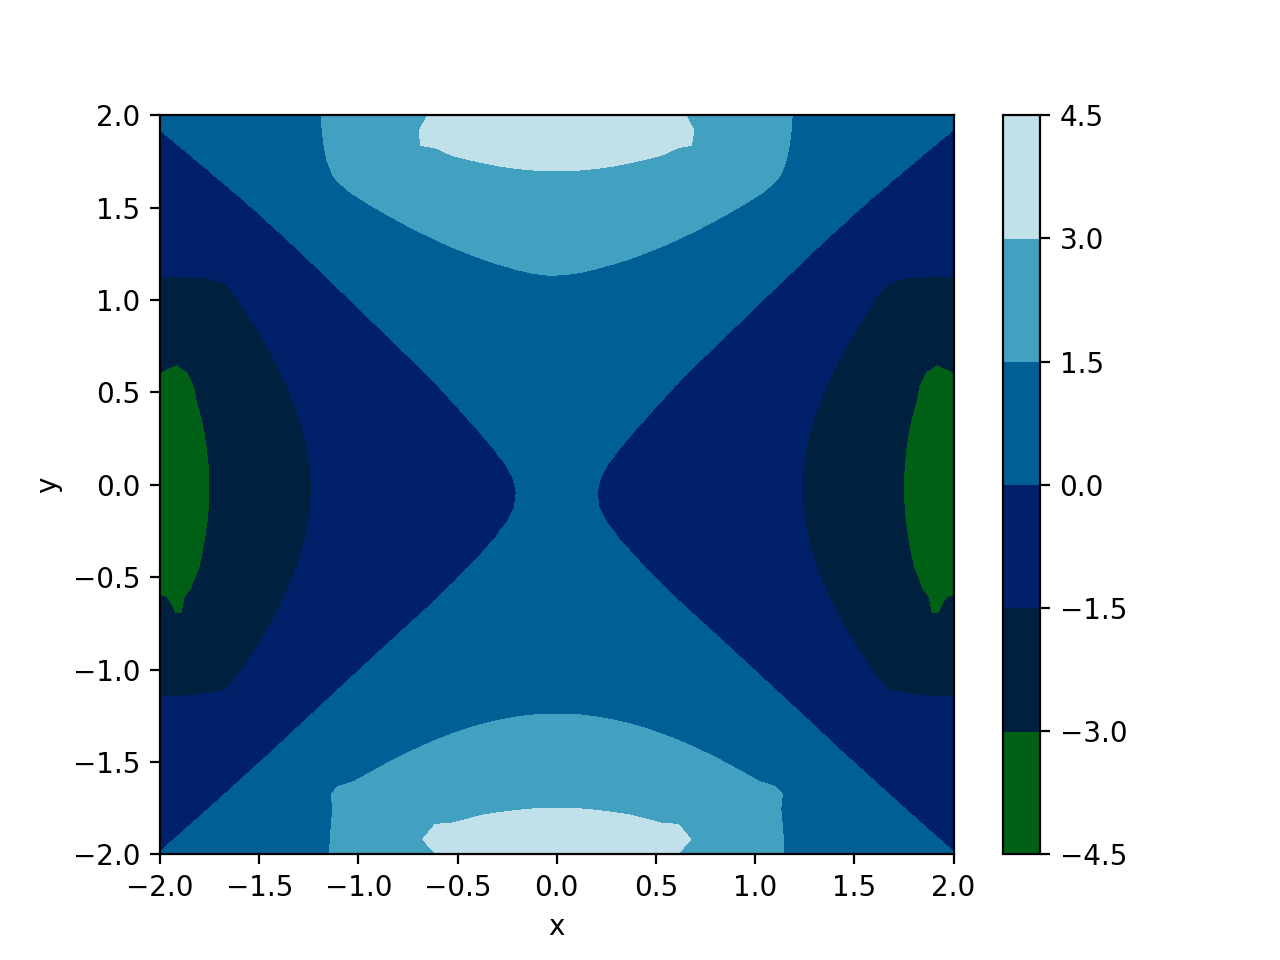

In [25]:
n_ = 50

x = np.linspace(-r2, r2, n_)
y = np.linspace(-r2, r2, n_)

xx_, yy_ = np.meshgrid(x, y)
zz_ = np.zeros([n_, n_])

for i, x_ in enumerate(x):
    for j, y_ in enumerate(y):
        zz_[i][j] = u_approx([x[i], y[j]])

# Draw contour
fig_contour,ax=plt.subplots(1,1)
cp = ax.contourf(xx_, yy_, zz_, cmap="ocean")
fig_contour.colorbar(cp)

# Draw curves
xxx = np.linspace(0, 2*np.pi, 100)
yyy = np.linspace(0, 2*np.pi, 100)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [26]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')

# surf = ax.plot_surface(xx_, yy_, zz_, rstride=1, cstride=1, linewidth=0.5, antialiased=True, cmap="ocean", edgecolor ='steelblue')

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

# plt.show()
# fig.savefig("x_approx.pdf", bbox_inches='tight')

<ipython-input-27-1496369dae94>:42: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ocean"))
  ocean.set_bad('k', alpha=0)
<ipython-input-27-1496369dae94>:43: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ocean"))
  ocean.set_under('k', alpha=0)


<IPython.core.display.Javascript object>


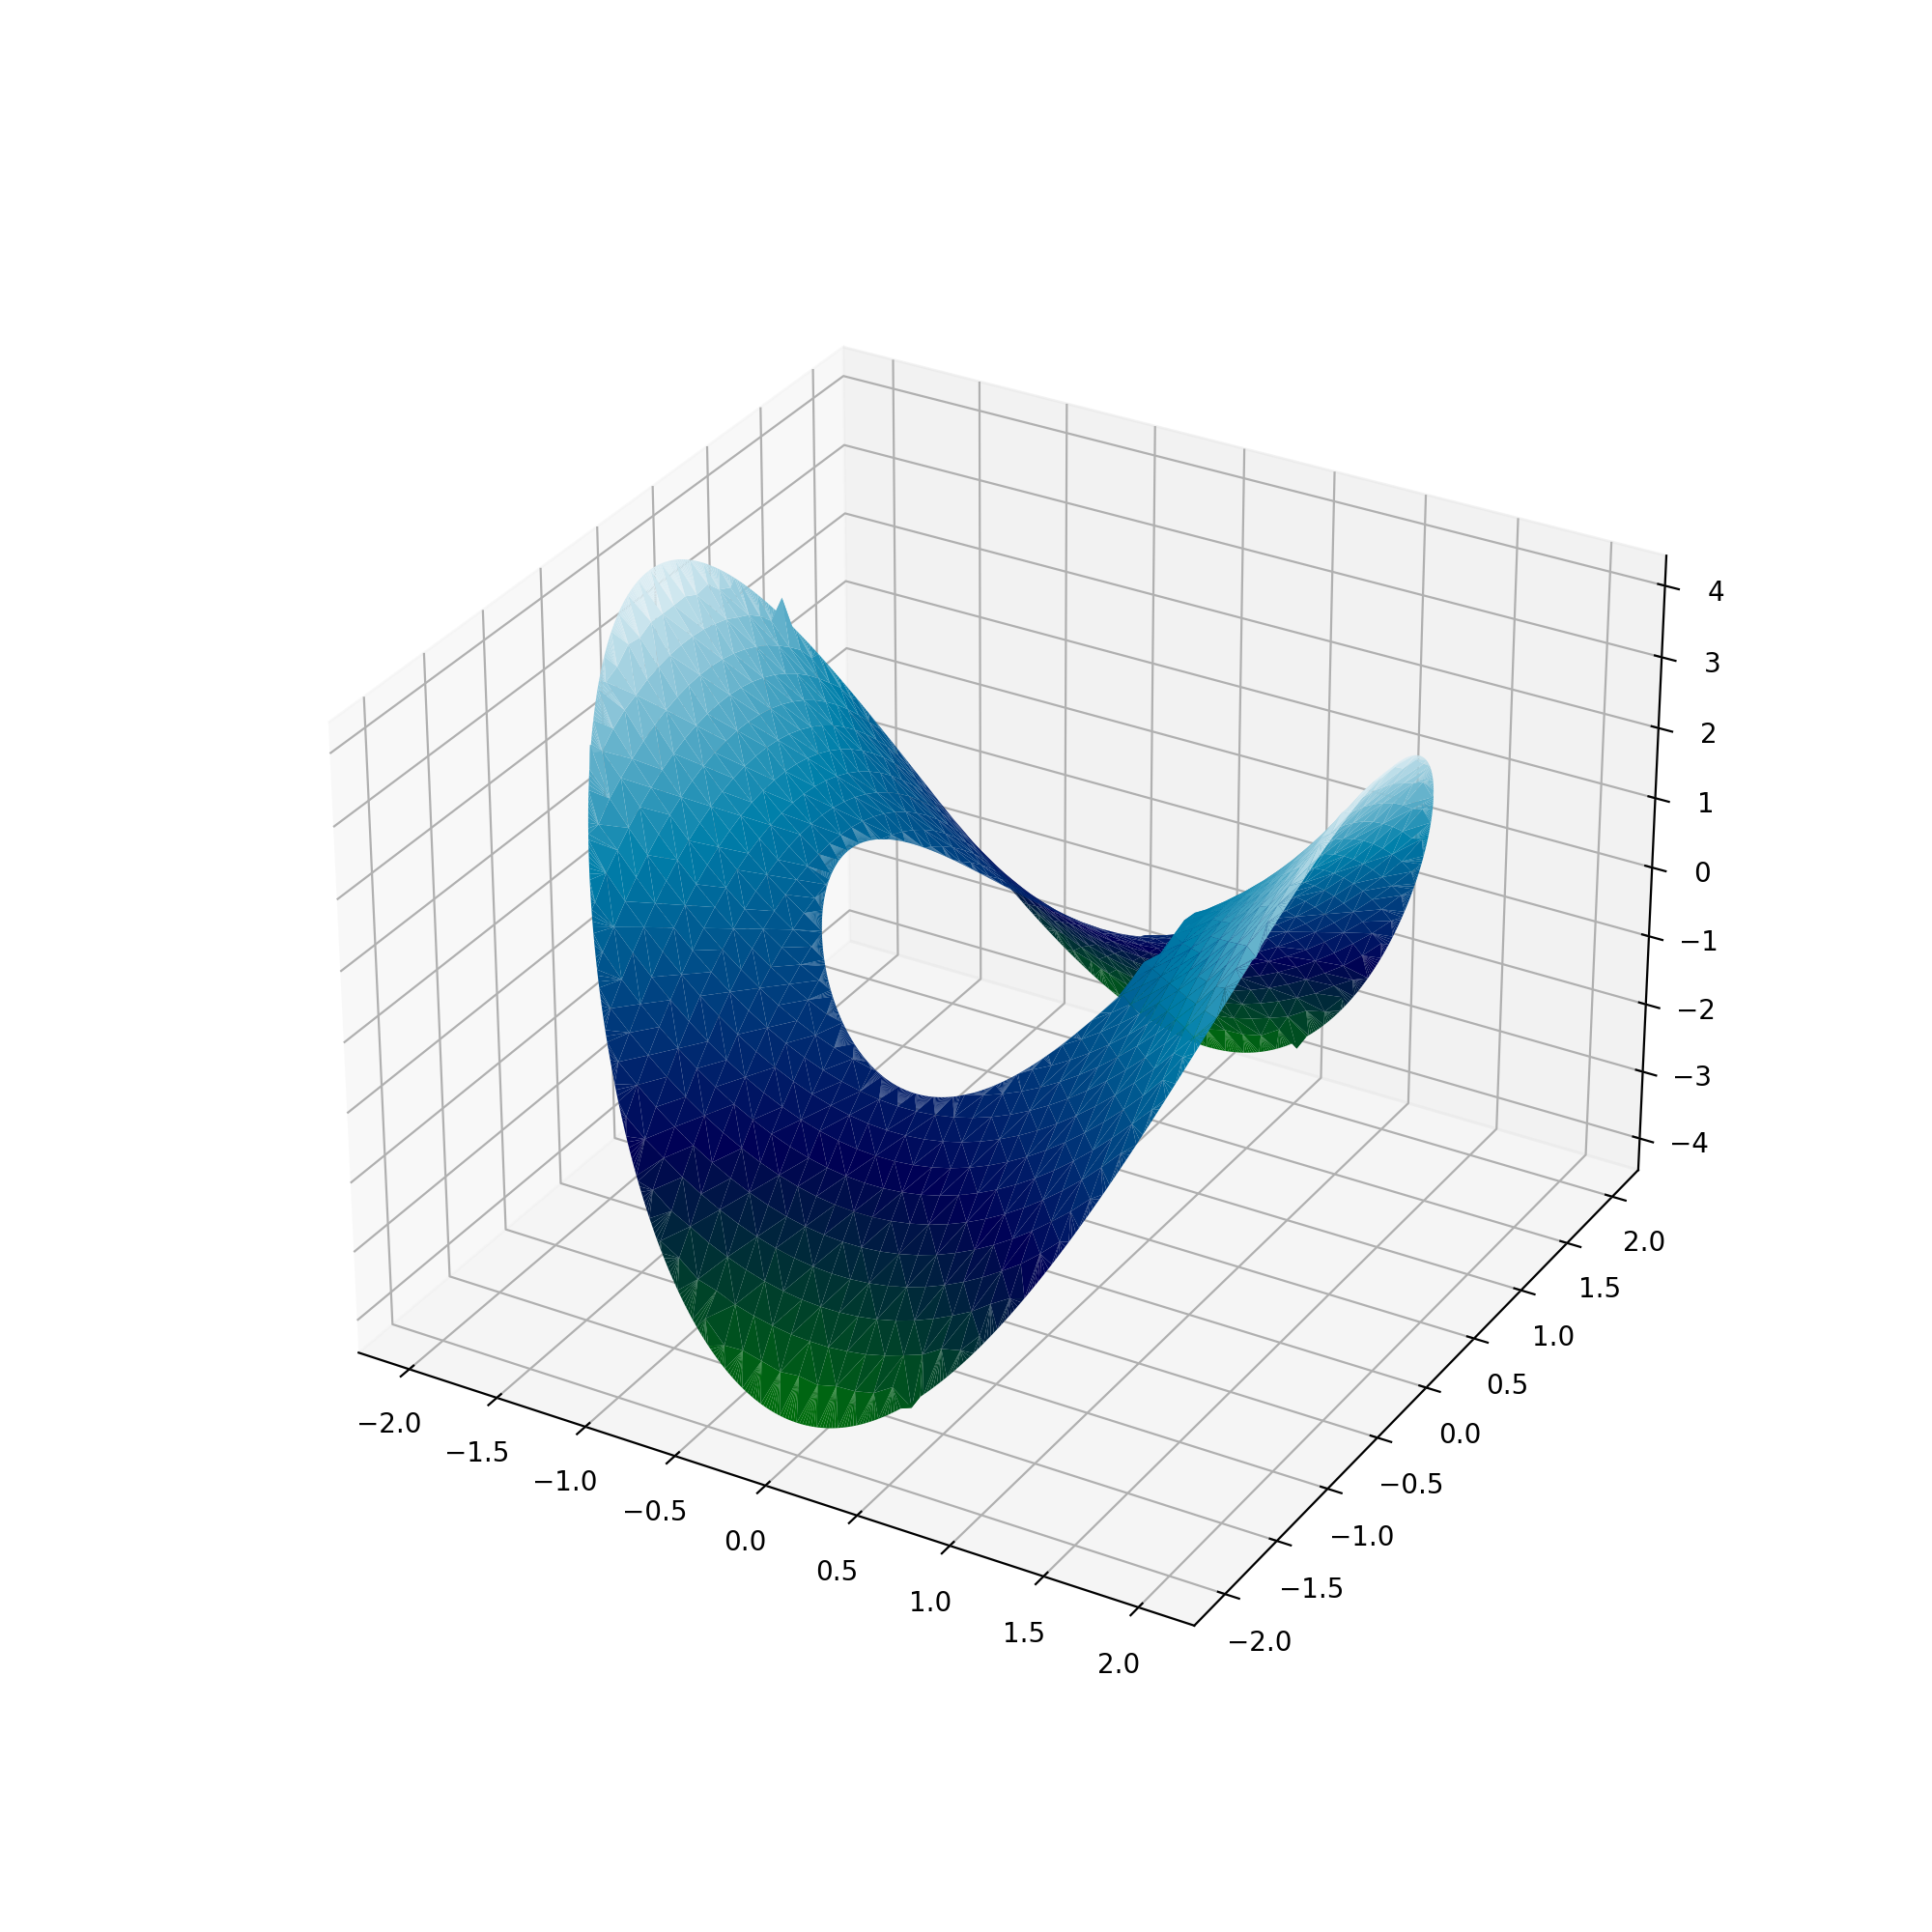

In [27]:
def plot_on_ring(f, r1, r2, mesh_num=20, bound_coef=3, indent=0.01, antialiased=True, save_to=None):
  
    def pol2cart(rho, phi):
        x = rho*np.cos(phi)
        y = rho*np.sin(phi)
        
        return [x, y]
    
    X, Y = np.meshgrid(np.linspace(-r2-indent, r2+indent, num=mesh_num), np.linspace(-r2-indent, r2+indent, num=mesh_num))
    Z = f(X.flatten(), Y.flatten()).reshape((mesh_num,mesh_num))
    
    mask = np.zeros_like(Z)
    mask[np.sqrt(X**2 + Y**2)<r2] = 1
    mask[np.sqrt(X**2 + Y**2)<r1] = 0
  
    Z_masked = Z.copy()
    Z_masked[mask == 0] = -1000
    Z_min = np.min(Z)
    Z_max = np.max(Z)

    X_c = []
    Y_c = []
    Z_c = []
    for rho in np.linspace(0, 2*np.pi, mesh_num*2*bound_coef):
        x, y = pol2cart(r2, rho)
        X_c.append(x)
        Y_c.append(y)
        # cheat, since if using u_approx we will cach ZeroDevisionError
        Z_c.append(u(x, y))

        x, y = pol2cart(r1, rho)
        X_c.append(x)
        Y_c.append(y)
        # cheat, since if using u_approx we will cach ZeroDevisionError
        Z_c.append(u(x, y))

    X_c = np.concatenate((X.flatten(), X_c))
    Y_c = np.concatenate((Y.flatten(), Y_c))
    Z_c = np.concatenate((Z_masked.flatten(), Z_c))
    
    ocean = cm.ocean
    ocean.set_bad('k', alpha=0)
    ocean.set_under('k', alpha=0)
        
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection = '3d')
    ax.plot_trisurf(X_c, Y_c, Z_c, linewidth=0, vmin=Z_min, vmax=Z_max, antialiased=True, cmap=ocean)
    ax.set_zlim([Z_min, Z_max])
    plt.show()
    
    if save_to != None:
        fig.savefig(save_to, bbox_inches='tight')
    
plot_on_ring(u_approx_arr, r1, r2, mesh_num=40, bound_coef=10, indent=0, save_to="results/ex1-approx.pdf")

In [28]:
# zz__ = np.zeros([n_, n_])

# for i, x_ in enumerate(x):
#     for j, y_ in enumerate(y):
#         zz__[i][j] = u(x[i], y[j])

# fig = plt.figure(figsize=(5, 5))
# ax = fig.gca(projection='3d')

# surf = ax.plot_trisurf(xx_.reshape(-1), yy_.reshape(-1), zz__.reshape(-1), rstride=1, cstride=1, linewidth=1, antialiased=True, cmap=cm.viridis)

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")

# plt.show()